In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

from simple_abstractor import SimpleAbstractorEncoder
from set_models import (
    SetCNNEmbedder,
    SetSequenceModel,
    SetClassifierLayer,
    SetVectorEmbedder,
)
from set_data_lit import SetTriplesDataModule
from set_data import SetCardBaseDataset


torch.set_float32_matmul_precision("medium")
pl.seed_everything(42, workers=True)

debug = True
save = False

use_official_cards = True
vectors_as_features = False


# parameters for both models and data
seq_len = 3
features_used = [0, 1, 2, 3]
feature_states_used = [0, 1, 2]

if len(feature_states_used) > 3:
    balanced_subset = True
else:
    balanced_subset = False


if use_official_cards:
    data_dir = "data"
    val_split = 0.01
    test_split = 0.01
else:
    data_dir = "data/custom_cards"
    val_split = 0.005
    test_split = 0.005
if vectors_as_features:
    val_split = 0.01
    test_split = 0.01


n_features = len(features_used)
label_choice = "is_set"

# prepare models
embedder_kwargs = dict()
abstractor_kwargs = {
    "num_layers": 1,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": True,
    "learn_symbol_per_position": True,
    "use_symbolic_attention": False,
    "object_dim": 64,
    "symbol_dim": 64,  # Using a different symbol dimension
    "num_heads": 4,
    "ff_dim": 128,
    "dropout": 0.1,
    "norm_att": False,
    "norm_ff": False,
    "resid_att": False,
    "resid_ff": False,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(),  # Different activation function
        # "activation": nn.Softmax(-1),
        # "activation": nn.Sigmoid(),
        # "activation": sparsemax,
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}

if vectors_as_features:
    card_embedder = SetVectorEmbedder(
        n_features=n_features, embed_dim=abstractor_kwargs["object_dim"]
    )
else:
    card_embedder = SetCNNEmbedder()

# abstractor_kwargs["use_pos_embedding"] = True
# abstractor_kwargs["use_learned_symbols"] = False
# abstractor_kwargs["learn_symbol_per_position"] = False
# abstractor_kwargs["use_symbolic_attention"] = False
AE1 = SimpleAbstractorEncoder(**abstractor_kwargs)
# abstractor_kwargs["object_dim"] = abstractor_kwargs["symbol_dim"]
# abstractor_kwargs["use_pos_embedding"] = False
# abstractor_kwargs["use_learned_symbols"] = False
# abstractor_kwargs["learn_symbol_per_position"] = False
# abstractor_kwargs["use_symbolic_attention"] = True

# AE2 = SimpleAbstractorEncoder(**abstractor_kwargs)
abstractor = nn.Sequential(
    AE1,
    #    AE2
)

# classifier = seq_model_PT.final_layer
seq_model = SetSequenceModel(
    base_embedder=card_embedder,
    # base_embedder=None,
    contextual_embedder=abstractor,
    seq_len=seq_len,
    # seq_len_final_layer=1,
    seq_len_final_layer=3,
    label_choice=label_choice,
    n_features=n_features,
    # aggregate_seq=MeanPoolModule(),
    aggregate_seq=nn.Flatten(),
    # classifier=classifier,
)

# prepare data
ds = SetCardBaseDataset(
    # image_embedder=cnn,
    # features_used=features_used,
    feature_states_used=feature_states_used,
    data_dir=data_dir,
    use_official_cards=use_official_cards,
)
if vectors_as_features:
    ds.set_card_representations_type("feature_vectors")
dm = SetTriplesDataModule(
    ds,
    batch_size=64,
    label_choice=label_choice,
    balanced_subset=balanced_subset,
    balanced_sampling=True,  # Enable balanced sampling
    balance_positions=True,
    val_split=val_split,
    test_split=test_split,
)
dm.setup()

name = "e2e_PT"
if vectors_as_features:
    name += "_vec"
elif use_official_cards:
    name += "_off"
else:
    name += "_custom"


if feature_states_used:
    name += "_"
    for f in feature_states_used:
        name += str(f)


# training
if not debug:
    logger = WandbLogger(
        project="first_project",
        name=name,
    )
else:
    logger = False

name += "posbal"

trainer_kwargs = dict(
    max_epochs=5,
    precision="16",
    logger=logger,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=15),
    ],
    val_check_interval=25,
    deterministic=True,
)

trainer = pl.Trainer(**trainer_kwargs)
trainer.validate(seq_model, dm)
if not debug:
    trainer.fit(seq_model, dm)
    trainer.test(seq_model, dm)

    if save:
        save_dir = "checkpoints"
        save_path = os.path.join(save_dir, name + ".pth")
        torch.save(seq_model, save_path)

    logger.experiment.finish()


Seed set to 42
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.5111371874809265
        val_loss            0.6935190558433533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [4]:
from set_data import SetTriplesDataset

In [83]:
ds = SetCardBaseDataset(use_official_cards=False, data_dir = "data/custom_cards", feature_states_used=[0,1,2,3])

In [84]:
ds_tr = SetTriplesDataset(ds)

20


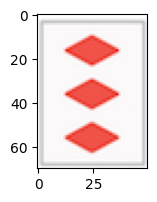

21


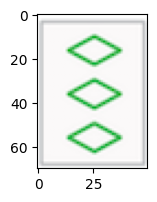

22


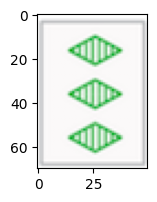

23


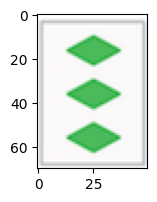

24


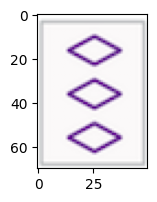

25


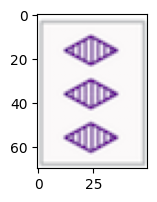

26


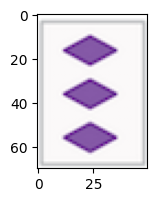

27


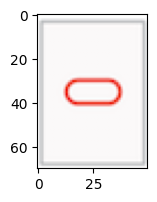

28


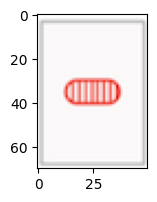

29


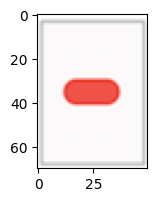

30


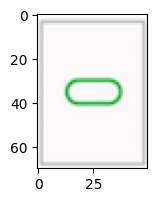

31


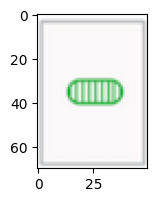

32


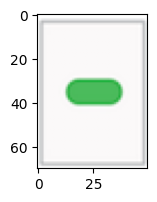

33


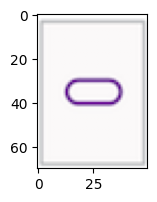

34


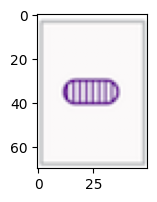

35


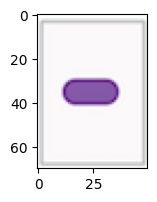

36


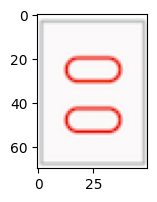

37


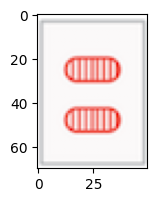

38


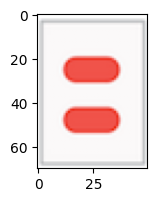

39


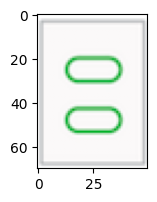

40


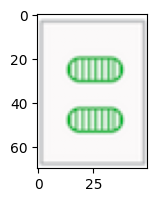

41


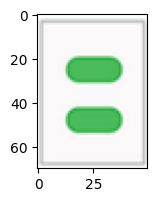

42


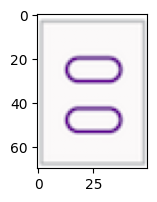

43


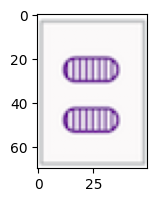

44


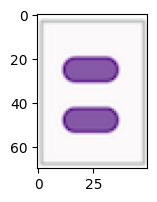

45


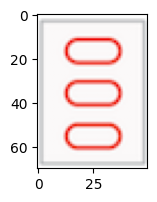

46


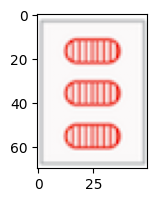

47


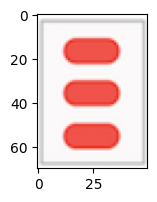

48


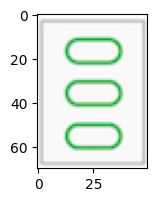

49


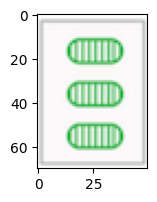

In [79]:
for i in range(20, 50):
    print(i)
    ds.plot_card(i)

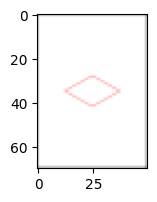

In [54]:
ds.plot_card(0)

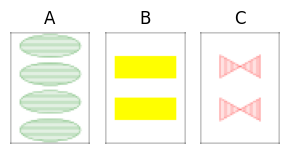

In [89]:
ds_tr.plot_triple([221,122,71])

In [12]:
import os
import torch
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle, Polygon
from itertools import product
import pickle


def generate_custom_card(
    number_index, color_index, pattern_index, shape_index, data_dir=None
):

    numbers = [1, 2, 3, 4]
    colors = ["red", "green", "purple", "yellow"]
    patterns = ["empty", "striped_vertical", "solid", "striped_horizontal"]
    shapes = ["diamond", "oval", "bar", "tie"]

    number = numbers[number_index]
    color = colors[color_index]
    pattern = patterns[pattern_index]
    shape = shapes[shape_index]

    plot_width = 4
    plot_heigth = 1.4 * plot_width

    # don't ask about this
    magic_correction_factor = 38.5
    magic_correction_factor = 38.5 / plot_width
    # magic_correction_factor = 3.85
    dpi = (50 * 70) / (plot_width * plot_heigth * magic_correction_factor)

    fig, ax = plt.subplots(
        figsize=(plot_width, plot_heigth), dpi=dpi
    )  # Adjusted figsize for 50x70 pixels
    ax.set_xlim([0, plot_width])
    ax.set_ylim([0, plot_heigth])
    ax.axis("off")

    colors_plt_codes = {
        "red": "r",
        "green": "g",
        "purple": "purple",
        "yellow": "yellow",
    }

    colors_plt_code = colors_plt_codes[color]

    y_spacing = plot_heigth / (number + 1) + 0.05 * plot_heigth

    biases = [
        plot_heigth * 0.05,
        plot_heigth * 0.075,
        plot_heigth * 0.1,
        plot_heigth * 0.125,
    ]
    for i in range(number):
        x = plot_width * 0.5

        y = (i + 1) * y_spacing - biases[number - 1]

        if shape == "diamond":
            shape_object = Polygon(
                [
                    [x - 0.5 * x, y],
                    [x, y + plot_heigth * 0.1],
                    [x + 0.5 * x, y],
                    [x, y - plot_heigth * 0.1],
                ]
            )
        elif shape == "oval":
            shape_object = Ellipse(
                (x, y), width=plot_width * 0.75, height=plot_heigth * 0.2
            )
        elif shape == "bar":
            shape_object = Rectangle(
                (x - 0.75 * x, y - plot_heigth * 0.1),
                width=plot_width * 0.75,
                height=plot_heigth * 0.2,
            )
        elif shape == "tie":
            shape_object = Polygon(
                [
                    [x - 0.5 * x, y - plot_heigth * 0.1],
                    [x - 0.5 * x, y + plot_heigth * 0.1],
                    [x + 0.5 * x, y - plot_heigth * 0.1],
                    [x + 0.5 * x, y + plot_heigth * 0.1],
                ]
            )

        # Set shading
        if pattern == "solid":
            shape_object.set_facecolor(colors_plt_code)
        elif pattern == "striped_vertical":
            shape_object.set_facecolor("none")
            shape_object.set_edgecolor(colors_plt_code)
            shape_object.set_hatch("||")
        elif pattern == "empty":
            shape_object.set_facecolor("none")
            shape_object.set_edgecolor(colors_plt_code)
        elif pattern == "striped_horizontal":
            shape_object.set_facecolor("none")
            shape_object.set_edgecolor(colors_plt_code)
            shape_object.set_hatch("--")

        ax.add_patch(shape_object)

    # Draw card border
    rect = plt.Rectangle(
        (0, 0.01),
        plot_width - 0.05,
        plot_heigth - 0.05,
        linewidth=2,
        edgecolor="black",
        facecolor="none",
    )
    ax.add_patch(rect)

    if data_dir:
        # Save plt fig as png
        file_path = os.path.join(
            data_dir,
            f"setcard_{number_index}{color_index}{pattern_index}{shape_index}.png",
        )
        plt.savefig(
            file_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.0,
        )
    else:
        plt.show()
    plt.close(fig)


def generate_all_custom_cards(data_dir="data/custom_cards"):
    all_cards = product(range(4), repeat=4)
    for card in all_cards:
        number_index, color_index, pattern_index, shape_index = card
        generate_custom_card(
            number_index, color_index, pattern_index, shape_index, data_dir
        )


def save_custom_cards_as_tensor(data_dir="data/custom_cards"):
    feature_states = [0, 1, 2, 3]
    n_cards = 256
    n_image_channels, height, width = 4, 70, 50
    card_feature_vectors = torch.LongTensor(list(product(feature_states, repeat=4)))

    cards_tensor = torch.empty(n_cards, n_image_channels, height, width)
    features_to_index = {}
    for i, card in enumerate(card_feature_vectors.tolist()):
        number_index, color_index, pattern_index, shape_index = card
        features_to_index[(number_index, color_index, pattern_index, shape_index)] = i
        image_file_path = os.path.join(
            data_dir,
            f"setcard_{number_index}{color_index}{pattern_index}{shape_index}.png",
        )
        im = mpimg.imread(image_file_path)
        # cards are vertical, but loaded horizontally
        cards_tensor[i] = torch.from_numpy(im).permute(2, 0, 1)

    save_tensor_file_path = os.path.join(
        data_dir,
        "custom_setcards.pt",
    )
    torch.save(cards_tensor, save_tensor_file_path)

    save_dict_file_path = os.path.join(
        data_dir,
        "features_to_index.pkl",
    )
    with open(save_dict_file_path, "wb") as f:
        pickle.dump(features_to_index, f)


In [13]:
generate_all_custom_cards()
save_custom_cards_as_tensor()

In [14]:
n_cards = 81
seq_len = 3

triples_imbalanced = torch.combinations(
            torch.arange(n_cards), seq_len
        )
if True:
    perm_indices = torch.argsort(
        torch.rand(
            triples_imbalanced.shape,
            generator=torch.Generator().manual_seed(42),
        ),
        dim=-1,
    )
    triples = torch.gather(triples_imbalanced, dim=-1, index=perm_indices)
else:
    self.triples = triples_imbalanced

In [22]:
with open('triples_imbalanced_numpy.npy', 'rb') as f:
    a = np.load(f)

In [21]:
triples_numpy = triples.detach().numpy()
triples_imbalanced_numpy = triples_imbalanced.detach().numpy()

with open('triples_numpy.npy', 'wb') as f:
    np.save(f, triples_numpy)

with open('triples_imbalanced_numpy.npy', 'wb') as f:
    np.save(f, triples_imbalanced_numpy)

In [17]:
triples_imbalanced.detach().numpy()

array([[ 0,  1,  2],
       [ 0,  1,  3],
       [ 0,  1,  4],
       ...,
       [77, 78, 80],
       [77, 79, 80],
       [78, 79, 80]])

In [2]:
import torch
import torch.nn as nn
import math

In [15]:
class AddLearnedPositionalEmbeddings(nn.Module):

    def __init__(
        self,
        embed_dim: int,
        scale: bool = True,
        dropout: float = 0.1,
        max_len: int = 3,
    ):
        super().__init__()
        self.scale = math.sqrt(embed_dim) if scale else 1

        self.position_embeddings = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """

        positions = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)
        positional_embedding = self.position_embeddings(positions)
        x = self.scale * x + positional_embedding
        return self.dropout(x)

In [9]:
a = torch.zeros(
    1, 3, 64, requires_grad=False
)
a.requires_grad

False

In [16]:
add_embed = AddLearnedPositionalEmbeddings(64)

In [21]:
a = add_embed(a)

In [22]:
a.requires_grad

True

In [1]:
max_seq_len=3
symbol_dim=64

In [ ]:
self.initial_symbol_sequence = torch.zeros(
    1, max_seq_len, self.symbol_dim, requires_grad=False
)

if self.use_pos_embedding:
    self.add_pos_embedding = AddPositionalEmbedding(vec_dim=symbol_dim)
    self.initial_symbol_sequence = self.add_pos_embedding(
        self.initial_symbol_sequence
    )

if self.use_learned_symbols:
    if self.learn_symbol_per_position:
        learned_symbols_shape = (1, max_seq_len, self.symbol_dim)
    else:
        learned_symbols_shape = self.symbol_dim

    self.initial_symbol_sequence += nn.Parameter(
        torch.randn(learned_symbols_shape),
        requires_grad=True,
    )

In [3]:
len(dm.train_dataset.indices)

1728

In [3]:
for batch in dm.train_dataloader():
    X, y = batch
    print(y)
    break

tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])


In [3]:
PT_name = "e2e_PT_vec_012"
PT_name[6:]

'_vec_012'

In [8]:
from set_data import SetTriplesDataset

In [9]:
ds =SetTriplesDataset(ds)

In [18]:
is_set_labels = ds.triple_is_set(ds.triples)
sets_indices = torch.where(is_set_labels)[0]
nonsets_indices = torch.where(~is_set_labels)[0]
perm = torch.randperm(
    nonsets_indices.size(0), generator=torch.Generator().manual_seed(42)
)
idx = perm[: sets_indices.size(0)]
nonsets_indices_subset = nonsets_indices[idx]

indices_subset = torch.cat((sets_indices, nonsets_indices_subset))
# self.triples = self.triples[indices_subset]


In [20]:
perm.shape

torch.Size([84240])

In [ ]:
sets_indices

In [17]:
indices_subset.shape

torch.Size([2160])

In [ ]:
# self.triples = self.triples[indices_subset]
perm = torch.randperm(
    self.triples.size(0), generator=torch.Generator().manual_seed(42)
)
self.triples = self.triples[perm][: self.max_size_subset]

In [15]:
perm = torch.randperm(
    indices_subset.size(0), generator=torch.Generator().manual_seed(42)
)

In [14]:
sets_indices

tensor([    0,   159,   237,  ..., 85296, 85300, 85319])

In [11]:
indices_subset

tensor([    0,   159,   237,  ..., 51744, 46614,  9476])

In [20]:
perm = torch.randperm(
    indices_subset.size(0), generator=torch.Generator().manual_seed(42)
)
perm[:400].shape

torch.Size([400])

In [16]:
indices_subset

tensor([    0,   159,   237,  ..., 51744, 46614,  9476])

In [4]:
PT_name = "e2e_PT_vec_012"
PT_name[6:]

'_vec_012'

In [6]:
seq_model.embedder[3:].requires_grad_(True)

Sequential(
  (3): SimpleAbstractorEncoder(
    (layers): ModuleList(
      (0-1): 2 x SimpleAbstractorEncoderLayer(
        (self_attn): SimpleMultiHeadAttention(
          (activation): Identity()
          (query_proj): Linear(in_features=64, out_features=32, bias=False)
          (key_proj): Linear(in_features=64, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (out_proj): Linear(in_features=32, out_features=32, bias=False)
        )
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (add_pos_embedding): AddPositionalEmbeddi

In [7]:
for batch in dm.val_dataloader():
    X, y = batch
    with torch.no_grad():
        o = seq_model.embedder[0:3](X)
    print(seq_model.embedder[3:](o))
    break

tensor([[[ 0.2433,  0.7596,  0.5623,  ...,  0.7551,  0.7021, -0.2628],
         [ 0.4952,  0.6690, -0.0058,  ...,  0.8542,  0.6902, -0.1323],
         [ 0.4983,  0.2724, -0.2452,  ...,  0.2293, -0.1148,  0.0901]],

        [[ 0.7434,  0.5695,  0.7526,  ...,  0.7712,  0.7880, -0.5262],
         [ 0.3994,  0.3318,  0.6233,  ...,  1.1341,  0.7518, -0.6946],
         [ 0.1733, -0.0628,  0.7325,  ...,  0.8349,  0.2481, -1.2290]],

        [[ 0.8610,  1.1737, -0.0392,  ...,  0.2479,  0.4586, -0.1794],
         [ 0.8332, -0.5478,  0.0487,  ..., -0.0533, -0.9643, -0.1209],
         [ 0.7521,  1.1613, -0.3748,  ...,  0.1891, -0.3303, -0.0866]],

        ...,

        [[ 0.9152,  0.7900,  0.0346,  ...,  0.6549,  0.7180, -0.0233],
         [ 0.5237,  0.2450,  0.2654,  ..., -0.4516, -2.4029, -0.1066],
         [ 1.2815,  1.1121,  1.0032,  ...,  0.8370, -0.2112,  0.2353]],

        [[ 0.3029,  0.6636,  0.0981,  ...,  0.8128,  0.5637, -0.3221],
         [ 1.2706,  0.5470,  0.5168,  ...,  0.4520,  0.

In [8]:
test_split

0.005

In [9]:
nn.Linear(4, 64)

Linear(in_features=4, out_features=64, bias=True)

In [7]:
len(dm.val_dataset.indices)

427

In [1]:
cnn = torch.load("./cnn_checkpoints/cnn_custom_0123.pth").base_embedder
torch.save(cnn, "./cnn_checkpoints/cnn_custom_0123.pth")


NameError: name 'torch' is not defined

In [21]:
data_dir = "data"
ds = SetCardBaseDataset(
    image_embedder=cnn,
    # features_used=features_used,
    feature_states_used=feature_states_used,
    data_dir=data_dir,
    use_official_cards=True,
)

RuntimeError: Given groups=1, weight of size [32, 4, 5, 5], expected input[1, 324, 70, 50] to have 4 channels, but got 324 channels instead

In [22]:
cnn

SetSequenceModel(
  (base_embedder): SetCNNEmbedder(
    (conv1): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=4, stride=4, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
  )
  (embedder): Sequential(
    (0): Flatten(start_dim=0, end_dim=1)
    (1): SetCNNEmbedder(
      (conv1): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
      (pool): MaxPool2d(kernel_size=4, stride=4, padding=1, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (fc1): Linear(in_features=32, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): Unflatten(dim=0, unflattened_size=(-1, 3))
  )
  (aggregate_seq): Flatten(start_dim=1, end_dim=-1)
  (final_layer): SetClassifierLayer(
    (layers): 

In [14]:
ds.card_images.permute(0,2,3,1).shape

torch.Size([256, 70, 50, 4])

In [18]:
inp = torch.Tensor(256, 70, 50, 4)
with torch.no_grad():
    a = cnn(inp)

RuntimeError: Given groups=1, weight of size [32, 4, 5, 5], expected input[1, 17920, 50, 4] to have 4 channels, but got 17920 channels instead

In [17]:
with torch.no_grad():
    ds.card_embeds = cnn(ds.card_images)

RuntimeError: Given groups=1, weight of size [32, 4, 5, 5], expected input[1, 1024, 70, 50] to have 4 channels, but got 1024 channels instead

In [2]:
ds

NameError: name 'ds' is not defined

In [4]:
torch.save(seq_model.base_embedder, "cnn_checkpoints/cnn_custom_0123.pth")


In [9]:
dm.triples_dataset.labels

tensor([[0, 0, 0,  ..., 0, 0, 2],
        [0, 0, 0,  ..., 0, 0, 3],
        [0, 0, 0,  ..., 0, 0, 3],
        ...,
        [1, 3, 3,  ..., 2, 1, 2],
        [0, 0, 1,  ..., 2, 0, 1],
        [0, 1, 2,  ..., 0, 3, 2]])

In [5]:
seq_model.final_layer

SetClassifierLayer(
  (layers): Sequential(
    (0): Linear(in_features=192, out_features=36, bias=True)
  )
  (criterion_fn): CrossEntropyLoss()
  (accuracy_fn): MulticlassAccuracy()
)

In [1]:
from set_models import (
    SetCNNEmbedder,
    SetSequenceModel,)
from simple_abstractor import SimpleAbstractorEncoder

import torch.nn as nn

In [2]:
AE1 = SimpleAbstractorEncoder(2)
AE2 = SimpleAbstractorEncoder(2)
abstractor = nn.Sequential(AE1, AE2)

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from simple_abstractor import SimpleAbstractorEncoder
from set_models import SetCNNEmbedder, SetSequenceModel
from set_data_lit import SetTriplesDataModule
from set_data import SetCardBaseDataset

embedder_kwargs = dict()
abstractor_kwargs = {
    "num_layers": 2,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": True,
    "object_dim": 64,
    "symbol_dim": 32,  # Using a different symbol dimension
    "num_heads": 4,
    "ff_dim": 128,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(),  # Different activation function
        # "activation": nn.Softmax(-1),
        # "activation": nn.Sigmoid(),
        # "activation": sparsemax,
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}
label_choice = "is_set"

ds = SetCardBaseDataset()
dm = SetTriplesDataModule(
    ds,
    batch_size=64,
    label_choice=label_choice,
    balanced_sampling=True,  # Enable balanced sampling
    val_split=0.01,
    test_split=0.0,
)
dm.setup()

cnn = SetCNNEmbedder()
# checkpoint = torch.load("./cnn_checkpoints/cnn_PT.pt")
# cnn.load_state_dict(checkpoint['model_state_dict'])
seq_len = 3
n_features = 4

A = SimpleAbstractorEncoder(**abstractor_kwargs)
seq_model = SetSequenceModel(
    base_embedder=cnn,
    contextual_embedder=A,
    seq_len=seq_len,
    label_choice=label_choice,
    n_features=n_features,
)


# logger = WandbLogger(project="first_project", name="triple_sim_e2e")
logger = False
trainer_kwargs = dict(
    max_epochs=4,
    logger=logger,
    #   callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
    val_check_interval=25,
    # check_val_every_n_epoch=1
)

trainer = pl.Trainer(**trainer_kwargs)
trainer.fit(seq_model, dm)

# torch.save(seq_model.state_dict(), "e2e_long_seq.pth")

# logger.experiment.finish()


/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/job/Documents/Thesis/code/experiments/checkpoints exists and is not empty.

  | Name                | Type                    | Params | Mode 
------------------------------------------------------------------------
0 | base_embedder       | SetCNNEmbedder          | 41.3 K | train
1 | contextual_embedder | SimpleAbstractorEncoder | 25.2 K | train
2 | embedder            | Sequential              | 66.5 K | train
3 | aggregate_seq       | Flatten                 | 0      | train
4 | final_layer         | SetClassifierLayer      | 97     | train
5 | acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [2]:
from probe import Probe

In [3]:
p = Probe(seq_model, classifier_type=nn.Linear, datasets=)

SyntaxError: positional argument follows keyword argument (2432755021.py, line 1)

In [ ]:
import torch
import torch.nn as nn
import ltn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from simple_abstractor import SimpleAbstractorEncoderLayer, SimpleAbstractorEncoder
from set_models import SetCNNEmbedder, SetClassifierLayer, SetSequenceModel
from set_data_lit import SetCardDataModule, SetTriplesDataModule,SetPairsDataModule
from set_data import SetCardBaseDataset, SetTriplesDataset
import os

In [ ]:
def taylorsoftmax(x, dim=-1):
    x_exp = torch.exp(x)
    sum_exp = torch.sum(x_exp, dim=dim, keepdim=True)
    return (x_exp + 0.5 * x_exp * (x - torch.log(sum_exp))) / sum_exp




In [ ]:
def load_2D_input():
    cnn = torch.load("./cnn_checkpoints/cnn.pt")
    classifier = torch.load("./checkpoints/2dclassifier.pt")
    return cnn, classifier

cnn, classifier = load_2D_input()

In [ ]:
abstractor_kwargs = {
    "num_layers": 3,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": True,
    "object_dim": 64,
    "symbol_dim": 32,  # Using a different symbol dimension
    "num_heads": 4,
    "ff_dim": 128,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(),  # Different activation function
        # "activation": nn.Softmax(-1),  
        # "activation": nn.Sigmoid(), 
        # "activation": sparsemax,
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}

In [ ]:
seq_len = 2
n_features = 4
label_choice = "pairwise_sim"

ds = SetCardBaseDataset(image_embedder=cnn, n_features=n_features)

dm = SetPairsDataModule(ds,label_choice=label_choice,
                        batch_size=1,
                          balanced_sampling=True,
                          val_split=0.01, 
                          test_split=0.)


dm.setup()

A = SimpleAbstractorEncoder(**abstractor_kwargs)
seq_model = SetSequenceModel(contextual_embedder=A, seq_len=seq_len, label_choice=label_choice, n_features=n_features)


In [ ]:
_ = seq_model(dm.val_dataset.dataset[[0,1]][0])

In [ ]:
logger = WandbLogger(project="first_project", name="pairs_sims_iden_1batch")
trainer_kwargs = dict(max_epochs=1, logger=logger, 
                    #   callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                        val_check_interval=32, 
                        # check_val_every_n_epoch=1
                        )

trainer = pl.Trainer(**trainer_kwargs)
trainer.fit(seq_model, dm)

logger.experiment.finish()

In [ ]:
assert False

In [ ]:
abstractor_kwargs = {
    "num_layers": 1,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": True,
    "object_dim": 64,
    "symbol_dim": 4,  # Using a different symbol dimension
    "num_heads": 2,
    "ff_dim": 128,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(-1),  # Different activation function
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}

In [ ]:
label_choice = "is_set"
seq_len = 3
n_features = 1

# embedder2D = lambda x: classifier.layers[:-1](cnn(x))
# ds = SetCardBaseDataset(image_embedder=embedder2D, n_features=n_features)

ds = SetCardBaseDataset(image_embedder=cnn, n_features=n_features)

dm = SetTriplesDataModule(ds,label_choice=label_choice, 
                          balanced_sampling=True,
                          val_split=0.01, 
                          test_split=0)
dm.setup()

A = SimpleAbstractorEncoder(**abstractor_kwargs)
seq_model = SetSequenceModel(contextual_embedder=A, seq_len=seq_len, label_choice=label_choice, n_features=n_features)


In [ ]:
logger = WandbLogger(project="first_project", name="is_set__SD4_2head_1feature")
trainer_kwargs = dict(max_epochs=1, logger=logger, 
                    #   callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                        val_check_interval=50, 
                        # check_val_every_n_epoch=1
                        )

trainer = pl.Trainer(**trainer_kwargs)
trainer.fit(seq_model, dm)

logger.experiment.finish()

In [ ]:
assert False

In [ ]:
Pred = ltn.Predicate(model)

In [ ]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

In [ ]:
model = SetClassifierLayer(label_choice="is_set", embed_dim=2, seq_len=1)
Pred = ltn.Predicate(model)


In [ ]:
import torch
import ltn
import matplotlib.pyplot as plt
import numpy as np

def generate_data(num_points, x_range=(-5, 5), y_range=(-5, 5), 
                   label_separation='linear', convex_factor=2):

    data_points = torch.rand((num_points, 2)) * torch.tensor([x_range[1]-x_range[0], y_range[1]-y_range[0]]) + torch.tensor([x_range[0], y_range[0]])

    if label_separation == 'linear':
        label1 = (data_points[:, 1] > data_points[:, 0]).float()
    elif label_separation == 'convex':
        label1 = (torch.norm(data_points, dim=1) < convex_factor).float()
    else:
        raise ValueError("Invalid label_separation method.")

    label2 = 1 - label1  # Second label is the inverse of the first

    return data_points, label1, label2


# Define predicates
class PredicateA(torch.nn.Module):
    def __init__(self):
        super(PredicateA, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class PredicateB(torch.nn.Module):
    def __init__(self):
        super(PredicateB, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Define connectives
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")


In [ ]:
num_points = 100
x_range=(-5, 5)
y_range=(-5, 5)
label_separation = "convex"
convex_factor = 3
data_points, label1, label2 = generate_data(num_points,x_range=x_range,y_range=y_range, label_separation=label_separation, convex_factor=convex_factor)

In [ ]:
constants = [ltn.Constant(features, trainable=False) for features in data_points]

In [ ]:
A = ltn.Predicate(PredicateA())
B = ltn.Predicate(PredicateB())

# Define the knowledge base
x1 = ltn.Variable("x1", data_points)
knowledge_base = []
sat_agg = ltn.fuzzy_ops.SatAgg()
# Training
optimizer = torch.optim.Adam(list(A.parameters()) + list(B.parameters()), lr=0.01)
for epoch in range(100):
    optimizer.zero_grad()
    knowledge_base = []
    knowledge_base += [A(c) for c in np.array(constants)[label1.bool()]]
    knowledge_base += [Not(A(c)) for c in np.array(constants)[~ label1.bool()]]
    knowledge_base += [Forall(
    x1,
    And(
        Implies(A(x1), Not(B(x1))),  # If A(x) is true, then B(x) is false
        Implies(Not(A(x1)), B(x1))   # If B(x) is true, then A(x) is false
    )
)]
    satisfiability = sat_agg(*knowledge_base)
    loss = 1. - satisfiability
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
x, y = torch.meshgrid(torch.linspace(x_range[0], x_range[1], 100), 
                      torch.linspace(y_range[0], y_range[1], 100))

# Stack x and y to create a 2D input tensor
input_tensor = torch.stack((x.flatten(), y.flatten()), dim=1)

In [ ]:
# Visualization
with torch.no_grad():
    pred_a = A.model(input_tensor)
    pred_b = B.model(input_tensor)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=label1, cmap='coolwarm')
plt.title("Ground Truth - Label 1")

plt.subplot(1, 3, 2)
plt.scatter(input_tensor[:, 0], input_tensor[:, 1], c=pred_a, cmap='coolwarm')
plt.title("Predicted A(x)")

plt.subplot(1, 3, 3)
plt.scatter(input_tensor[:, 0], input_tensor[:, 1], c=pred_b, cmap='coolwarm')
plt.title("Predicted B(x)")

plt.tight_layout()
plt.show()

In [ ]:
assert False

In [ ]:
ds = SetCardBaseDataset()
dm = SetTriplesDataModule(
        ds,
        batch_size=64,
        label_choice=label_choice,
        balanced_sampling=True,  # Enable balanced sampling
        val_split=0.1,
        test_split=0.,
    )
dm.setup()

# cnn = SetCNNEmbedder()
cnn = torch.load("./cnn_checkpoints/cnn.pt")
# cnn.load_state_dict(checkpoint['model_state_dict'])
AE = SimpleAbstractorEncoder(**abstractor_kwargs)

seq_model = SetSequenceModel(base_embedder=cnn, contextual_embedder=AE, seq_len=3, label_choice=label_choice)

In [ ]:
def batch_to_theory(batch, formulas, label_fn):
    data, labels = batch
    x1 = ltn.Variable("x1", data)
    x2 = ltn.Variable("x2", data)
    x3 = ltn.Variable("x3", data)

    theory = []

    # Ground the formulas for each data point in the batch
    for i, x in enumerate(data):
        # Convert data point to a constant
        x_constant = ltn.Constant(x)

        # Get ground truth literals for the data point
        ground_truth = label_fn(x, labels[i])  # Assuming labels are accessible

        # Add ground truth and grounded formulas to the theory
        theory.extend(ground_truth)
        for formula in formulas:
            grounded_formula = formula.ground({x: x_constant})
            theory.append(grounded_formula)

    return theory

# Example usage assuming your SetSequenceModel provides labels:
def example_label_fn(x, label):
    """Example label function assuming binary classification and a predicate C."""
    l_a = ltn.Constant(torch.tensor([1., 0.]))  # One-hot encoding for class A
    l_b = ltn.Constant(torch.tensor([0., 1.]))  # One-hot encoding for class B
    return [C(x, l_a)] if label == 0 else [C(x, l_b)]  

# Example formulas (modify these based on your specific knowledge)
formulas = [
    Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
]


In [ ]:
C